In [274]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from afinn import Afinn

import string

We start by importing negative/positive data into a single dataframe, and then applying simple pre-processing methods

In [135]:
path = 'data/twitter-datasets/'

In [140]:
data = None

with open(f'{path}train_pos_full.txt', 'r') as f:
    data = pd.DataFrame(data = f.read().splitlines())
    data.columns = ['tweet']
    data['label'] = 1
    
with open(f'{path}train_neg_full.txt', 'r') as f:
    df_neg = pd.DataFrame(data = f.read().splitlines())
    df_neg.columns = ['tweet']
    df_neg['label'] = -1
    data = data.append(df_neg, ignore_index = False)


In [275]:
def preprocess_tweet(tweet: str) -> str:
    # remove "<user>" anonymization
    res = tweet.replace('<user> ', '')
    
    # remove punctuation
    res = res.translate(str.maketrans('', '', string.punctuation))
    
    # remove hashtags
    # res = res.replace('#', '')
    
    return " ".join(res.split())

data['tweet'] = data.tweet.apply(lambda msg: preprocess_tweet(msg))


Our first lexicon-based classification will make use of the `Afinn` library

In [143]:
afn = Afinn()

data['score_afn'] = data.tweet.apply(lambda msg: afn.score(msg))

# map strictly positive values to 1, strictly negative to -1 and zero values to 0
data['sentiment_afn'] = data.score_afn.apply(lambda score: 1 if score > 0 else (-1 if score < 0 else 0))

data

,tweet,label,score_afn,sentiment_afn
0,i dunno justin read my mention or not only jus...,1,3.0,1
1,because your logic is so dumb i wont even crop...,1,-3.0,-1
2,just put casper in a box looved the battle cra...,1,-1.0,-1
3,thanks sir dont trip lil mama just keep doin y...,1,2.0,1
4,visiting my brother tmr is the bestest birthda...,1,2.0,1
...,...,...,...,...
1249995,im so sorry to u guys are ridiculous,-1,-4.0,-1
1249996,i cant find food coloring anywhere,-1,0.0,0
1249997,same here but tort wonder why you chose crime ...,-1,-3.0,-1
1249998,keyless entry remote fob clicker for 2005 buic...,-1,0.0,0


We then apply a similar method using `SentiWordNet` which is able to assess positivity, negativity, and objectivity

In [144]:
import nltk

from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer

from nltk.tag import pos_tag

nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/wexus/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/wexus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wexus/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [237]:
# inspired from https://srish6.medium.com/sentiment-analysis-using-the-sentiwordnet-lexicon-1a3d8d856a10

In [146]:
def tag_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


In [147]:
def score_sentiwordnet(tweet: str) -> str:
    token = nltk.word_tokenize(tweet)
    tagged = nltk.pos_tag(token)
    
    sentiment, token_count = 0.0, 0
    
    lemmatizer = WordNetLemmatizer()
    for word, tag in tagged:
        wn_tag = tag_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            continue
            
        lemma = lemmatizer.lemmatize(word, pos = wn_tag)
        if not lemma:
            continue

        synsets = wn.synsets(lemma, pos = wn_tag)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())

        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        token_count += 1
    
    return sentiment


In [148]:
data['score_swn'] = data.tweet.apply(lambda msg: score_sentiwordnet(msg))
data['sentiment_swn'] = data.score_swn.apply(lambda score: 1 if score > 0 else (-1 if score < 0 else 0))
data

,tweet,label,score_afn,sentiment_afn,score_swn,sentiment_swn
0,i dunno justin read my mention or not only jus...,1,3.0,1,-0.625,-1
1,because your logic is so dumb i wont even crop...,1,-3.0,-1,-0.125,-1
2,just put casper in a box looved the battle cra...,1,-1.0,-1,0.000,0
3,thanks sir dont trip lil mama just keep doin y...,1,2.0,1,1.000,1
4,visiting my brother tmr is the bestest birthda...,1,2.0,1,1.000,1
...,...,...,...,...,...,...
1249995,im so sorry to u guys are ridiculous,-1,-4.0,-1,-1.250,-1
1249996,i cant find food coloring anywhere,-1,0.0,0,0.000,0
1249997,same here but tort wonder why you chose crime ...,-1,-3.0,-1,0.250,1
1249998,keyless entry remote fob clicker for 2005 buic...,-1,0.0,0,-1.125,-1


We will also make use of `VADER` which is trained specifically on social media data

In [149]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/wexus/nltk_data...


True

In [150]:
sid = SentimentIntensityAnalyzer()

data['polarity_vader'] = data.tweet.apply(lambda tweet: sid.polarity_scores(tweet))
data['score_vader'] = data.polarity_vader.apply(lambda polarity: polarity['compound'])
data['sentiment_vader'] = data.score_vader.apply(lambda score: 1 if score > .05 else (-1 if score < -0.5 else 0))

Finally our last lexicon will be `TextBlob` which can estimate both polarity (sentiment) and subjectivity

In [255]:
from textblob import TextBlob

data['score_tb'] = data.tweet.apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

Our task is to classify a tweet as "positive" or "negative". All of the techniques proposed also distinguish a "neutral" case for sentiment values in the interval $[-\epsilon, \epsilon]$ for $\epsilon$ some small non-negative value. We will try variants to classify these neutral values into positive or negative and pick the best performing one according to the accuracy metric

In [163]:
data = data.reset_index(drop = True)

In [276]:
LABELS = list(data.label.unique())
performances = list()

for s_name in ['sentiment_afn', 'sentiment_swn', 'sentiment_vader']:
    best_decision, best_performance = None, -1
    for decision in LABELS:
        tweak_sentiment = data[s_name].apply(lambda x: decision if x == 0 else x)
        performance = (data.label == tweak_sentiment).sum() # number of correctly guessed labels

        if performance > best_performance:
            best_decision = decision
            best_performance = performance

        perf = performance/data.shape[0]
        performances.append([s_name, decision, perf])
        print(f'{s_name}: decision={decision}, perf={perf}')
        
performances = pd.DataFrame(performances, columns = ['s_name', 'decision', 'performance'])


sentiment_afn: decision=1, perf=0.5871364
sentiment_afn: decision=-1, perf=0.620614
sentiment_swn: decision=1, perf=0.5740196
sentiment_swn: decision=-1, perf=0.5464812
sentiment_vader: decision=1, perf=0.5428384
sentiment_vader: decision=-1, perf=0.6302932


In [266]:
bins = 100
performances_tb = list()

for step in range(bins + 1):
    threshold = 2 * step/bins - 1 # value between -1 and 1 (bounds for textblob sentiments)
    tweak_sentiment = data.score_tb.apply(lambda x: -1 if x <= threshold else 1)
    performance = (data.label == tweak_sentiment).sum() # number of correctly guessed labels
    
    performances_tb.append([threshold, performance / data.shape[0]])
    
performances_tb = pd.DataFrame(performances_tb, columns = ['threshold', 'performance'])


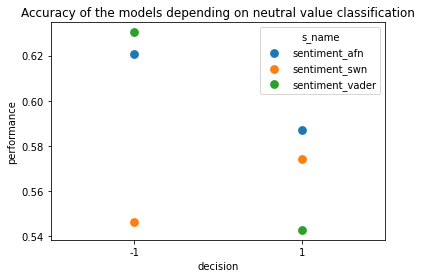

In [287]:
sns.pointplot(data = performances, x = 'decision', y = 'performance', hue = 's_name', join = False)
plt.title('Accuracy of the models depending on neutral value classification')
plt.savefig('accuracy_lexicon.png')
plt.show()

In [283]:
performances.loc[performances.performance.idxmax()]

s_name         sentiment_vader
decision                    -1
performance           0.630293
Name: 5, dtype: object

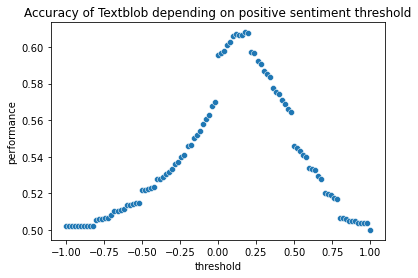

In [288]:
sns.scatterplot(data = performances_tb, x = 'threshold', y = 'performance')
plt.title('Accuracy of Textblob depending on positive sentiment threshold')
plt.savefig('accuracy_textblob.png')
plt.show()

In [284]:
performances_tb.loc[performances_tb.performance.idxmax()]

threshold      0.180000
performance    0.608052
Name: 59, dtype: float64

Why is the lexicon-based technique performing "so bad"? Probably abbreviations and tweeter jargon (hashtags)

In [236]:
data.tweet.sample(5)

755703                               lmaoo ayeee i like that
1034103    my brother bday tomarrow haha im gonna make so...
755802     whether one direction are in australia america...
2195191            thats weird it has just stopped working 3
988817     owww touchy monkey boi dont cry silly silly jo...
Name: tweet, dtype: object